In [3]:
# Setup cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import os

sns.set(style="whitegrid")
INPUT = "../data/processed/task2/reviews_with_themes.csv"
OUT = "data/processed/task2/analysis_outputs/"
os.makedirs(OUT, exist_ok=True)

df = pd.read_csv(INPUT, parse_dates=['review_date'], dayfirst=False, infer_datetime_format=True)
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df.shape, df['bank_name'].unique()


C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_21016\282463947.py:15: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(INPUT, parse_dates=['review_date'], dayfirst=False, infer_datetime_format=True)


((1200, 8),
 array(['Commercial Bank of Ethiopia', 'Bank of Abyssinia', 'Dashen Bank'],
       dtype=object))

Sanity checks (counts / missing)

In [4]:
# quick checks
print("Total reviews:", len(df))
print(df.groupby('bank_name').size())
print("Missing review_text:", df['review_text'].isna().sum())
print("Missing sentiment:", df['sentiment_label'].isna().mean())


Total reviews: 1200
bank_name
Bank of Abyssinia              400
Commercial Bank of Ethiopia    400
Dashen Bank                    400
dtype: int64
Missing review_text: 0
Missing sentiment: 0.0


Sentiment Trend

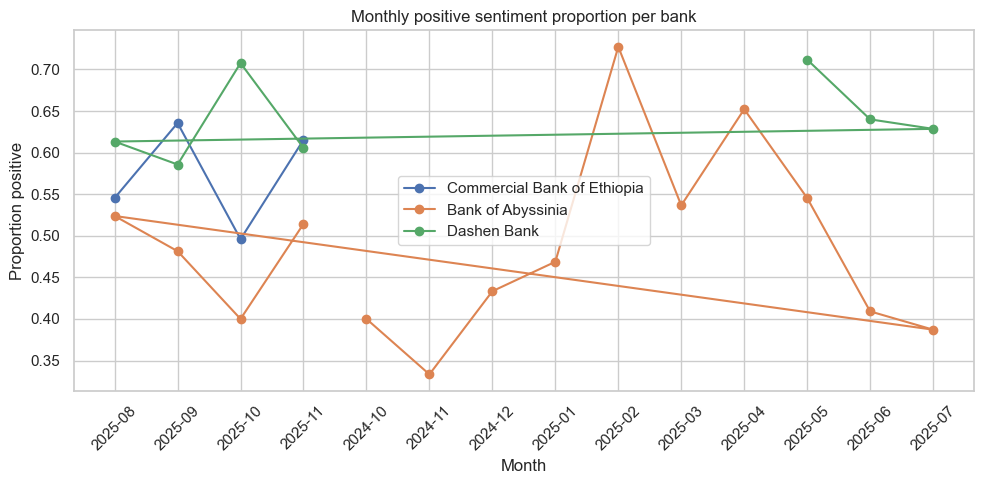

In [5]:
# monthly sentiment proportions and mean score per bank
df['month'] = df['review_date'].dt.to_period('M').astype(str).fillna('unknown')
trend = df.groupby(['bank_name','month','sentiment_label']).size().reset_index(name='count')
# convert to proportions per month
total_month = df.groupby(['bank_name','month']).size().reset_index(name='total')
trend = trend.merge(total_month, on=['bank_name','month'])
trend['prop'] = trend['count'] / trend['total']

# plot example: line chart of positive proportion over time per bank
plt.figure(figsize=(10,5))
for bank in df['bank_name'].unique():
    bank_pos = trend[(trend['bank_name']==bank) & (trend['sentiment_label']=='POSITIVE')].sort_values('month')
    plt.plot(bank_pos['month'], bank_pos['prop'], marker='o', label=bank)
plt.xticks(rotation=45)
plt.title("Monthly positive sentiment proportion per bank")
plt.ylabel("Proportion positive")
plt.xlabel("Month")
plt.legend()
plt.tight_layout()
plt.savefig(OUT+"sentiment_trend_positive.png")
plt.show()


Rating Distriubtion

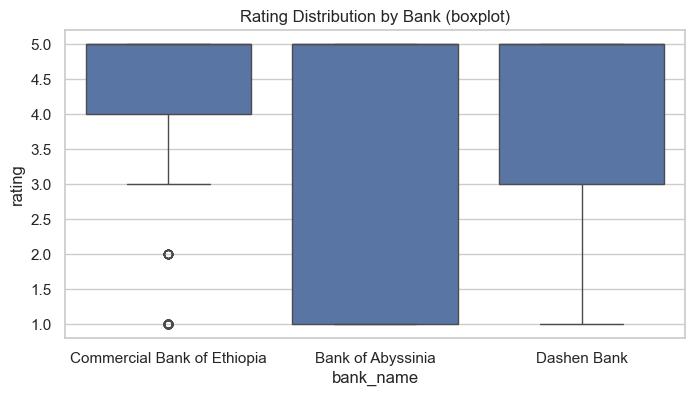

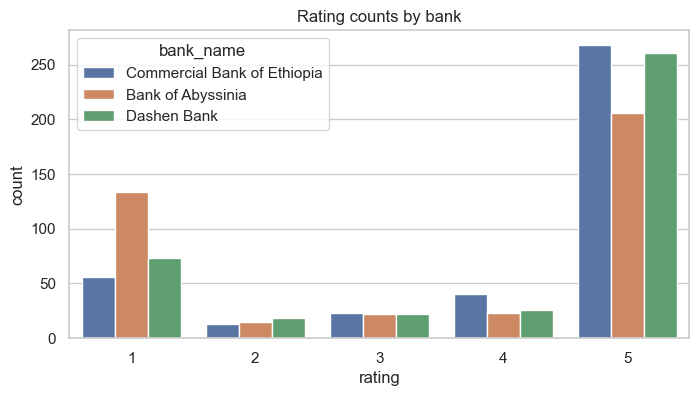

In [6]:
plt.figure(figsize=(8,4))
sns.boxplot(x='bank_name', y='rating', data=df)
plt.title("Rating Distribution by Bank (boxplot)")
plt.savefig(OUT+"rating_boxplot.png")
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(x='rating', hue='bank_name', data=df, order=sorted(df['rating'].dropna().unique()))
plt.title("Rating counts by bank")
plt.savefig(OUT+"rating_counts.png")
plt.show()


Theme Per Banks

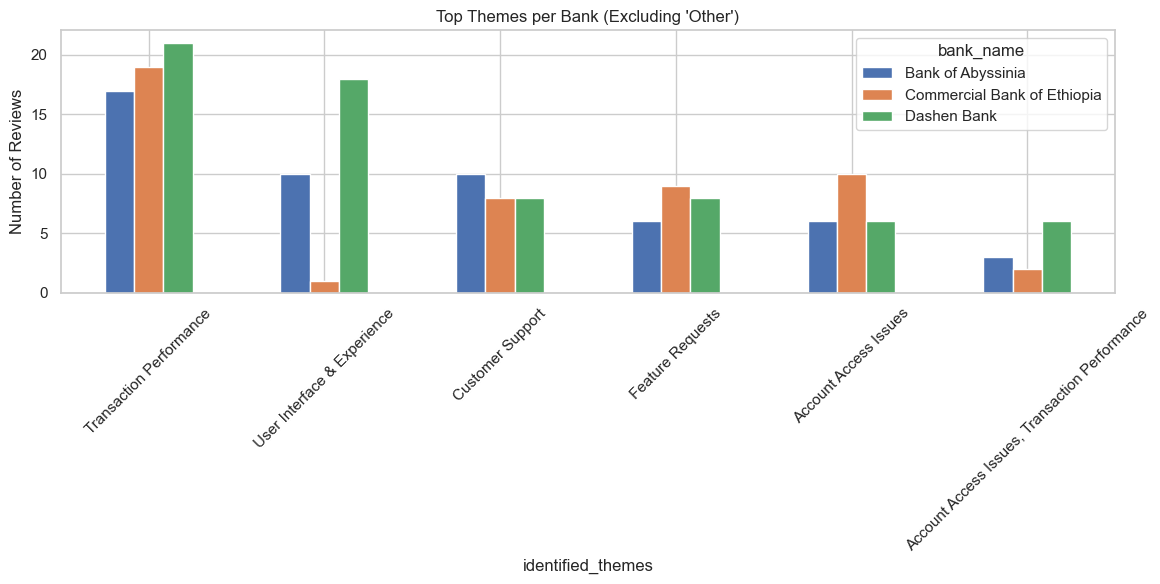

In [ ]:

#  TOP THEMES PER BANK (EXCLUDING OTHER)


tmp = df.copy()

# Build pivot table safely (NO review_id used)
mat = tmp.pivot_table(
    index='identified_themes',
    columns='bank_name',
    values='rating',
    aggfunc='count',
    fill_value=0
)

# Remove dominant "Other"
if "Other" in mat.index:
    mat = mat.drop("Other")

# Sort by total frequency
mat = mat.loc[
    mat.sum(axis=1).sort_values(ascending=False).index
]

# Plot
mat.head(6).plot(kind="bar", figsize=(12,6))
plt.title("Top Themes per Bank (Excluding 'Other')")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{OUT}top_themes.png")
plt.show()


Word Cloud Per Bank

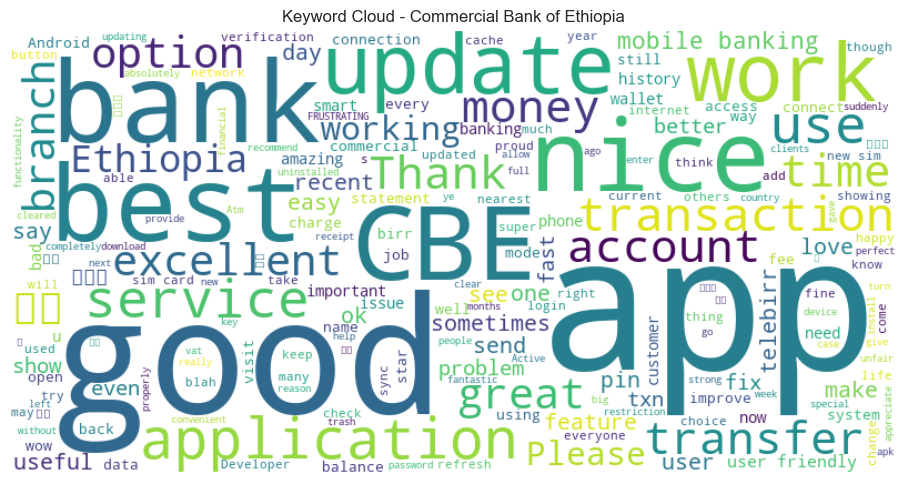

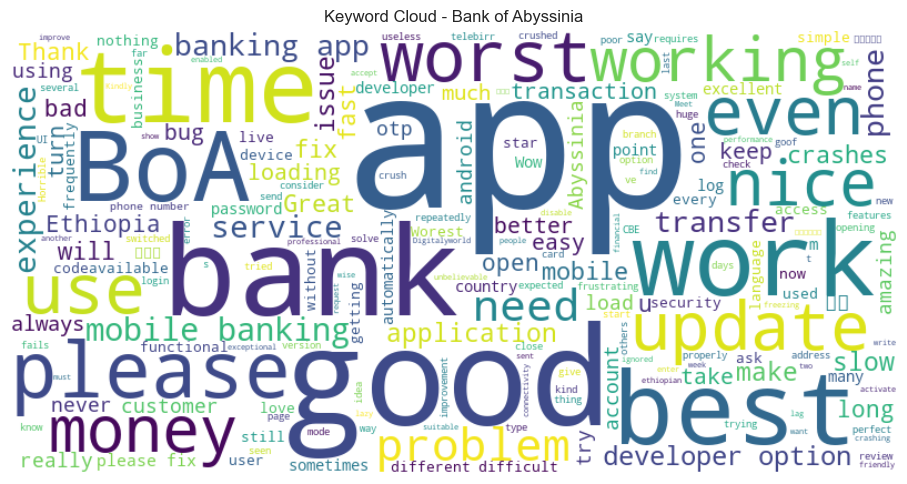

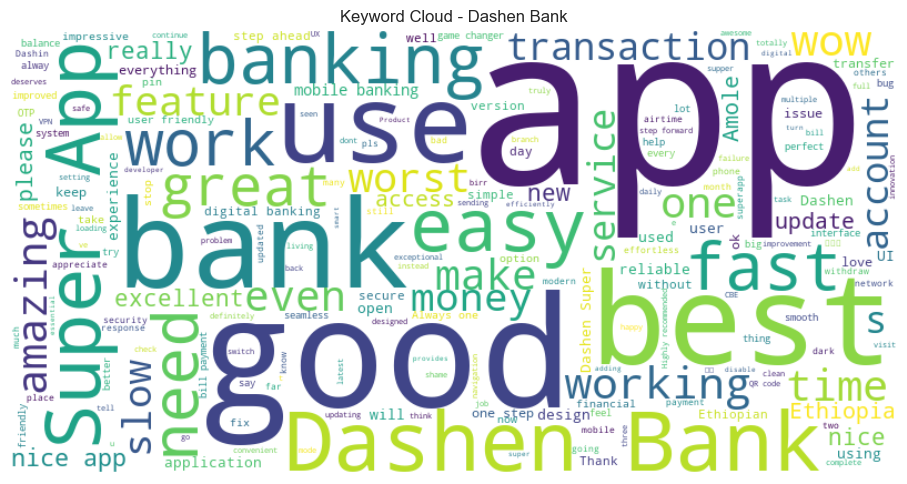

In [ ]:

#  WORD CLOUD PER BANK


for bank in df['bank_name'].unique():
    text = " ".join(df[df['bank_name']==bank]['review_text'].dropna())

    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Keyword Cloud - {bank}")
    plt.tight_layout()
    plt.savefig(f"{OUT}wordcloud_{bank.replace(' ','_')}.png")
    plt.show()
